# Theory

Matrix factorization which is a supervised learning has some limitations like 
- The difficulty of using side features (that is, any features beyond the query ID/item ID). As a result, the model can only be queried with a user or item present in the training set.
- Relevance of recommendations. Most likely popular items tend to be recommended for everyone, especially when using dot product as a similarity measure. It is better to capture specific user interests.

Deep neural network (DNN) models can address these limitations of matrix factorization. DNNs can easily incorporate query features and item features (due to the flexibility of the input layer of the network), which can help capture the specific interests of a user and improve the relevance of recommendations.

In this notebook we will implement a Softmax DNN model which treats the problem as a multiclass prediction problem in which:

- The input is the user query.
- The output is a probability vector with size equal to the number of items in the corpus, representing the probability to interact with each item; for example, the probability to click on or watch a YouTube video.

Input
The input to a DNN can include:

- dense features (for example, watch time and time since last watch)
- sparse features (for example, watch history and country)

Unlike the matrix factorization approach, we can also add side features such as age or country. 
x = input vector

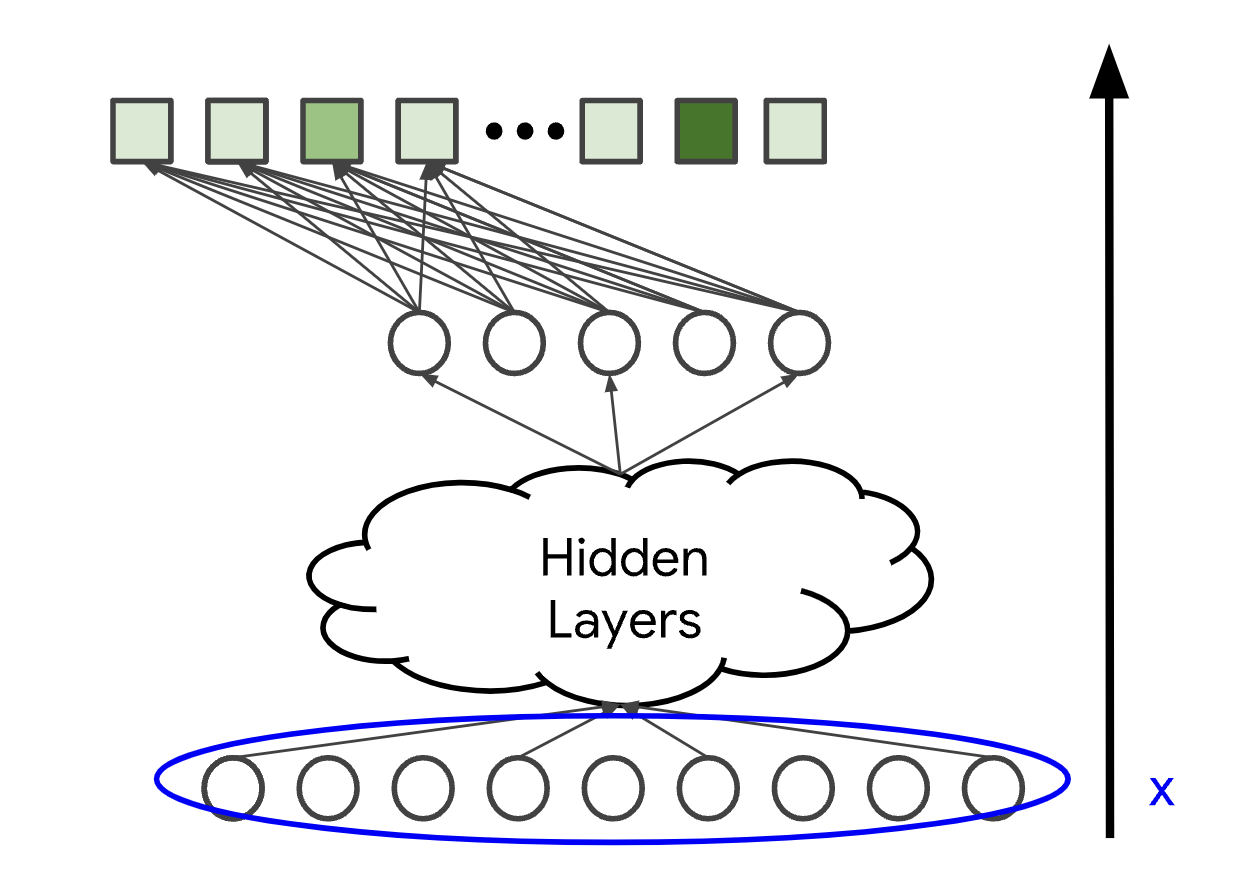


## Model Architecture
The model architecture determines the complexity and expressivity of the model. By adding hidden layers and non-linear activation functions (for example, ReLU), the model can capture more complex relationships in the data. However, increasing the number of parameters also typically makes the model harder to train and more expensive to serve. We will denote the output of the last hidden layer by 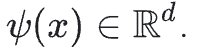

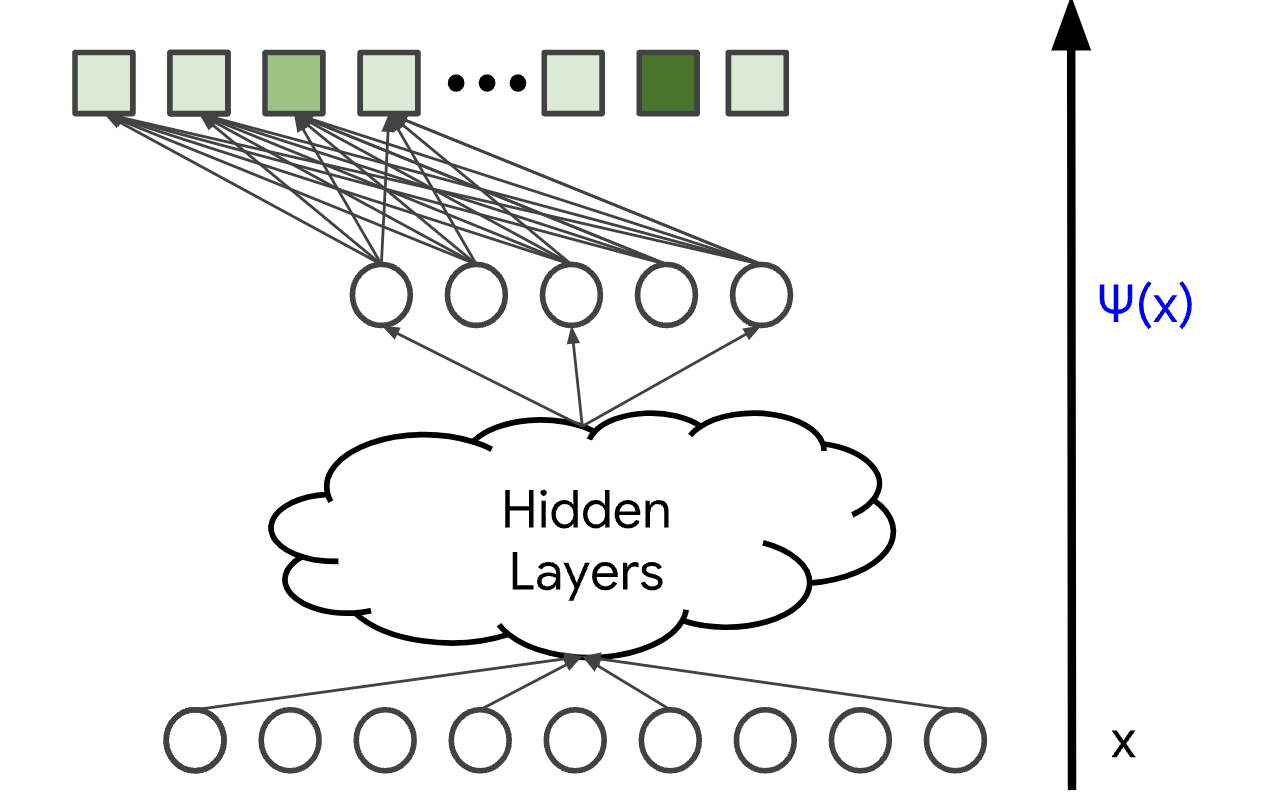

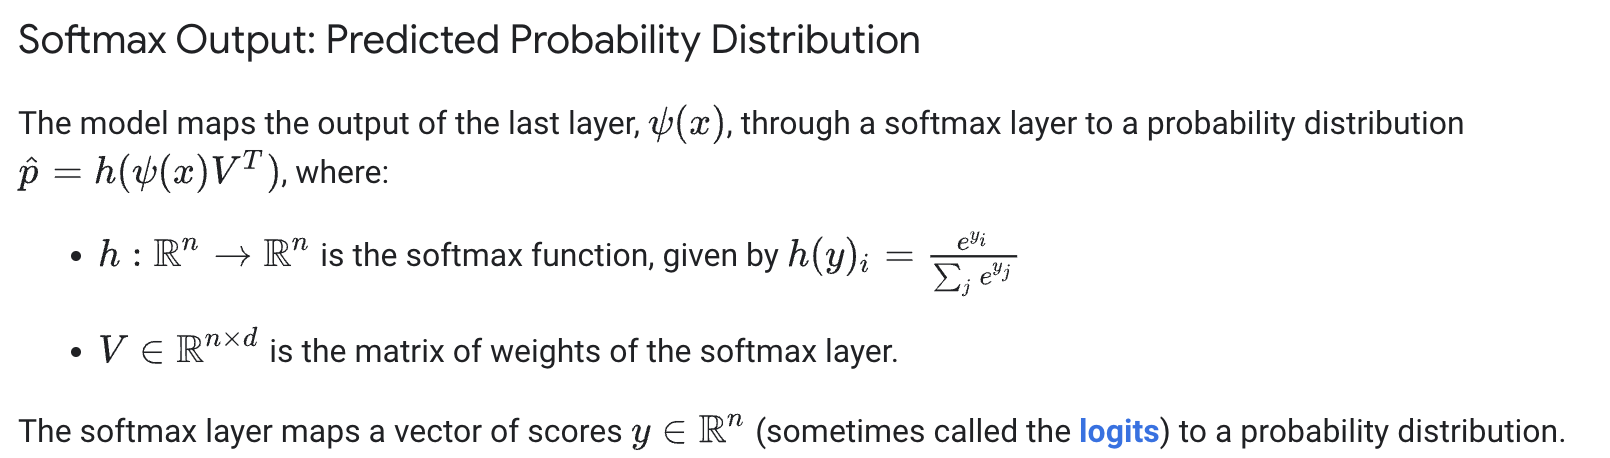

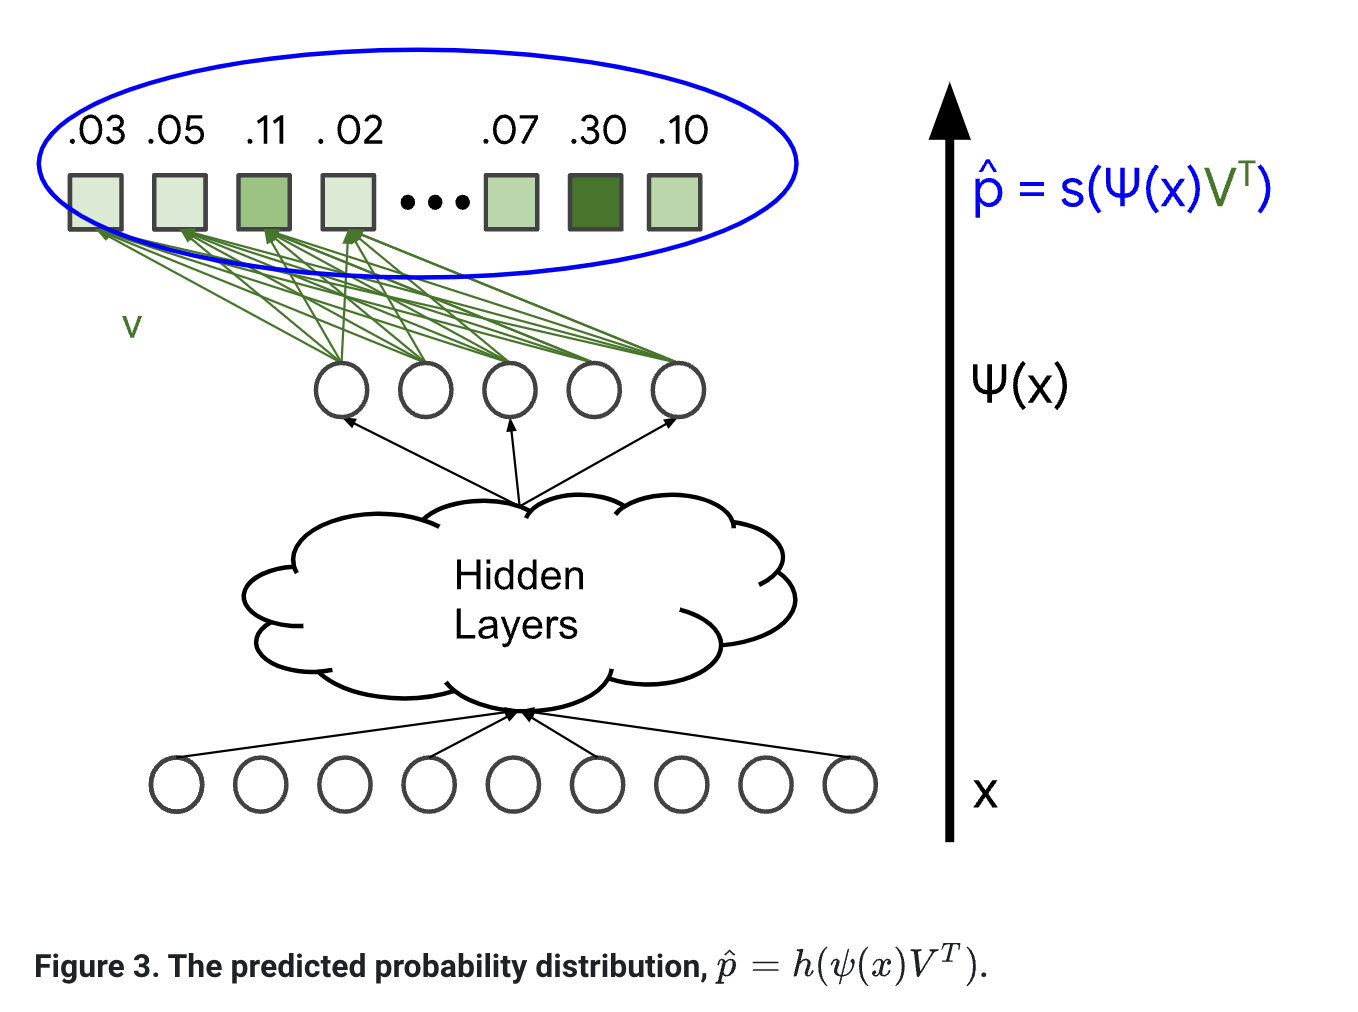

## Loss function
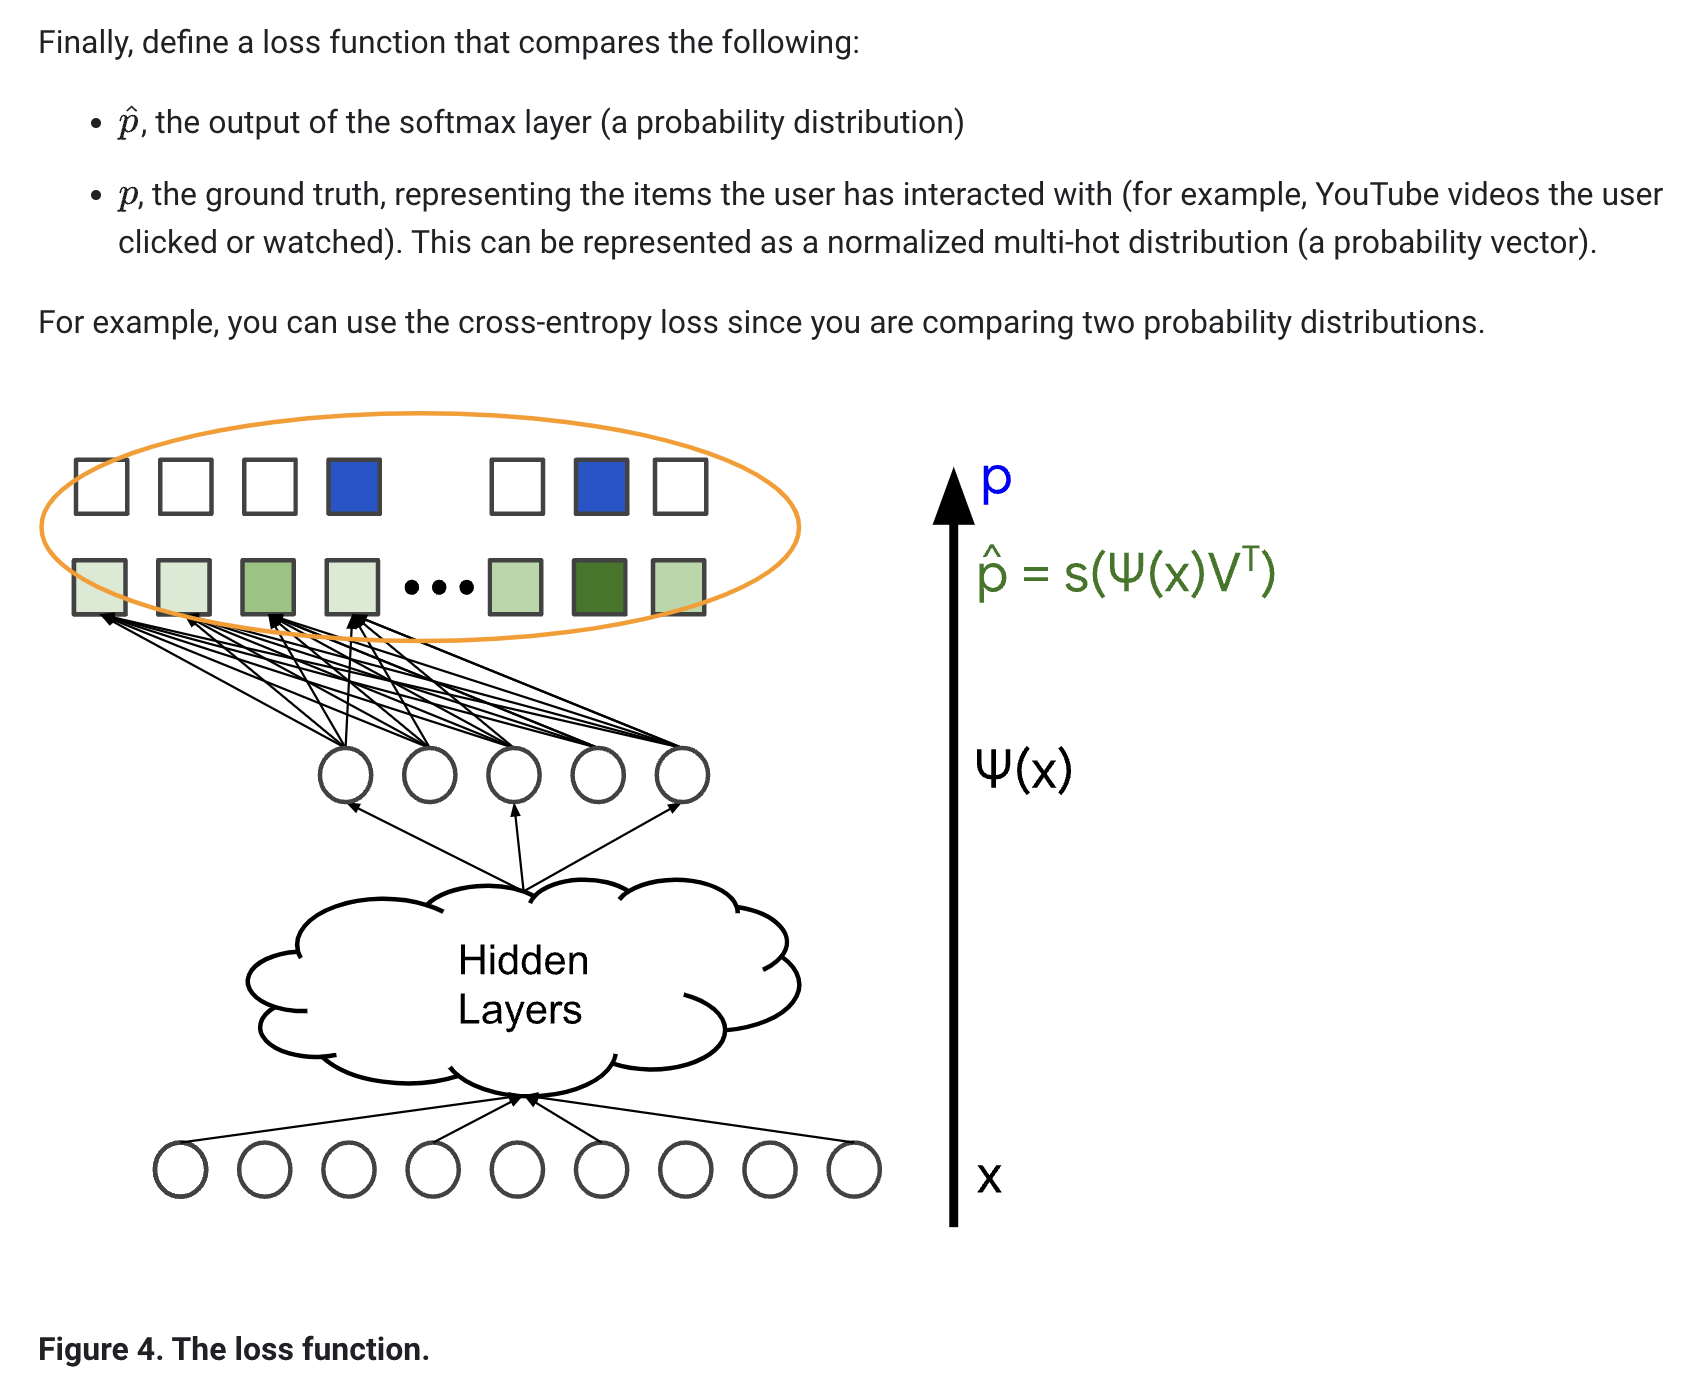
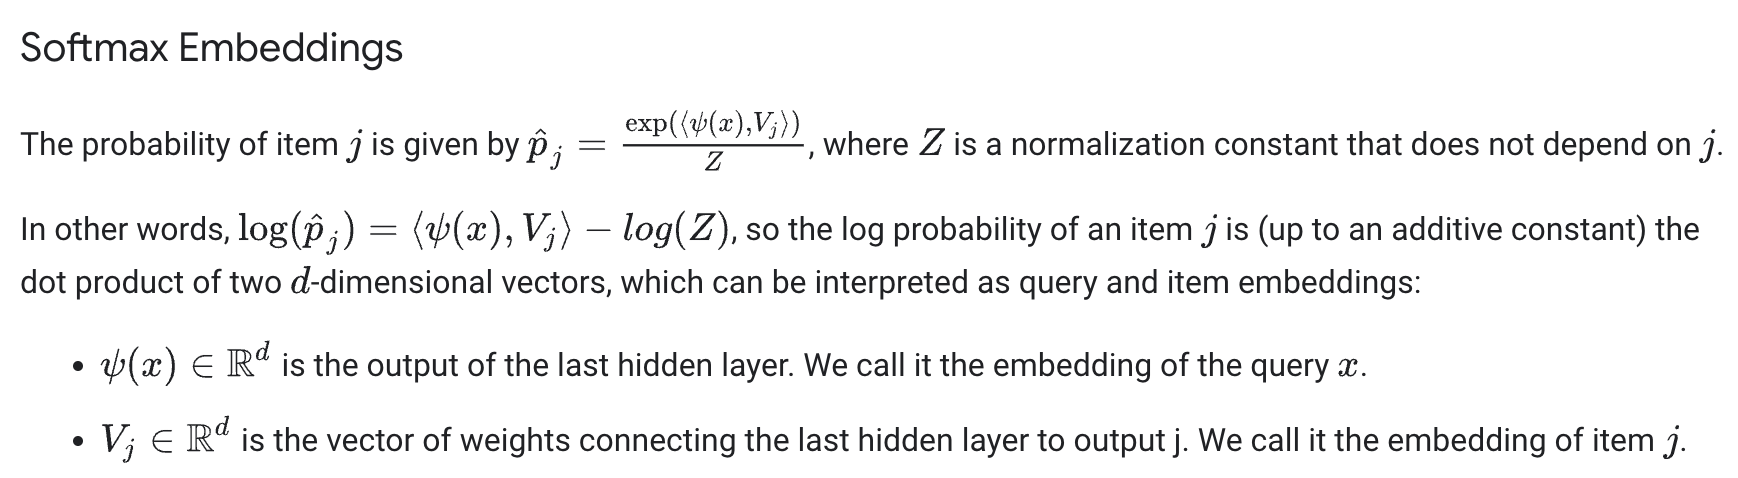

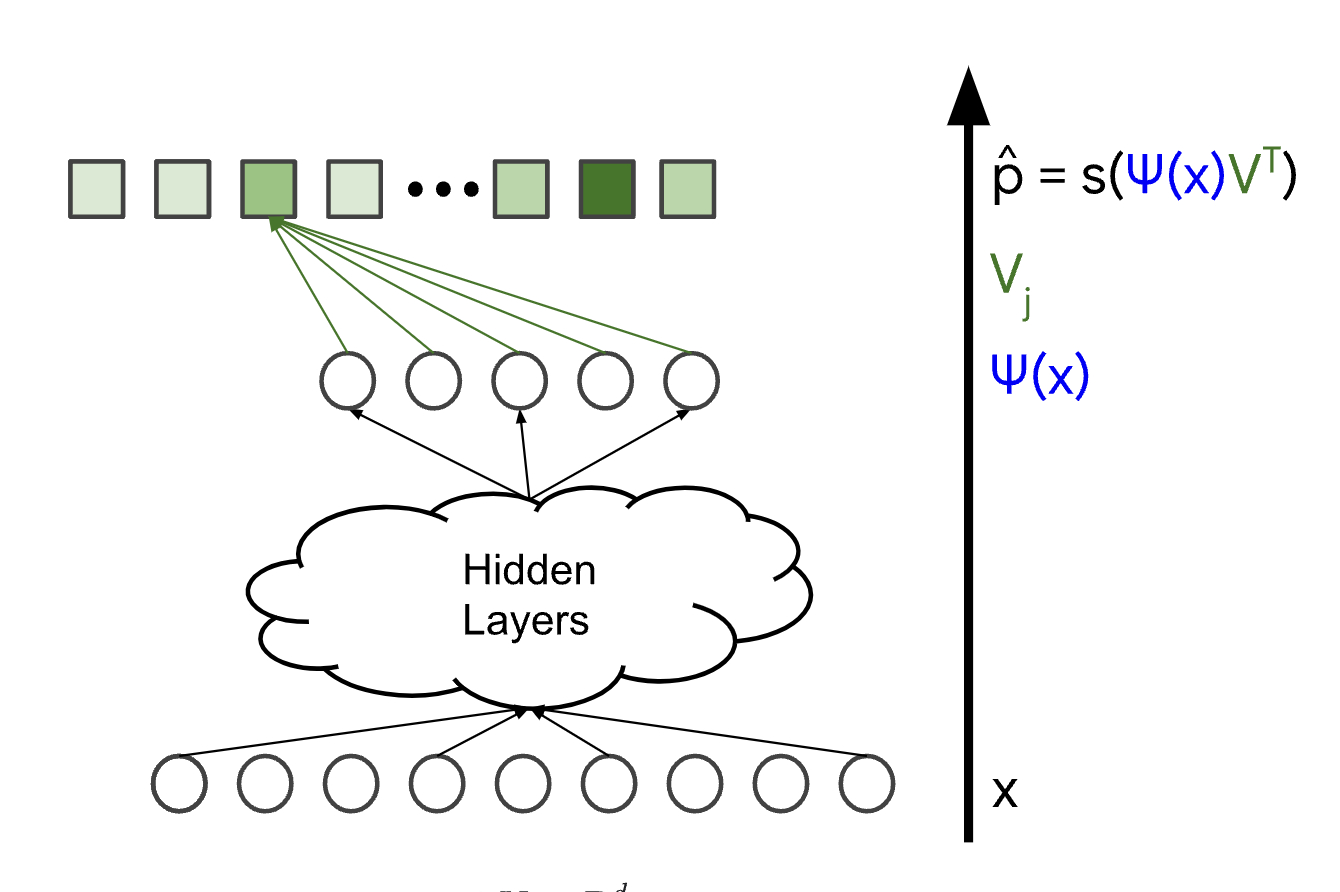



# Implementation of softmax DNN

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
import altair as alt
import datapane as dp
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
tf.compat.v1.enable_eager_execution()
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Concatenate,Add,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

In [4]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

In [5]:
input_file_path = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/raw/'
output_files = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/outputs'

## Data Exploration

In [6]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

In [7]:
file_name = 'ml-100k/u.user'

In [8]:
users = pd.read_csv(f"{input_file_path}/{file_name}"
    , sep='|', names=users_cols, encoding='latin-1')

In [9]:
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [10]:
# Unique values in each column
for column in users.columns:
    print(column, len(users[column].unique()))

user_id 943
age 61
sex 2
occupation 21
zip_code 795


In [11]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
file_name = 'ml-100k/u.data'
ratings = pd.read_csv(f"{input_file_path}/{file_name}", sep='\t', names=ratings_cols, encoding='latin-1')

In [12]:
genre_cols = ['title', 'id',]
file_name = 'ml-100k/u.genre'
genre = pd.read_csv(f"{input_file_path}/{file_name}", sep='|', names=genre_cols, encoding='latin-1')

In [13]:
genre_c_name=list(genre['title'])

In [14]:
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_c_name
file_name = 'ml-100k/u.item'
movies = pd.read_csv(f"{input_file_path}/{file_name}", sep='|', names=movies_cols, encoding='latin-1')

## Training of Softmax

We then create a function that generates an example batch, such that each example contains the following features:

- movie_id: A tensor of strings of the movie ids that the user rated.
- genre: A tensor of strings of the genres of those movies
- year: A tensor of strings of the release year.

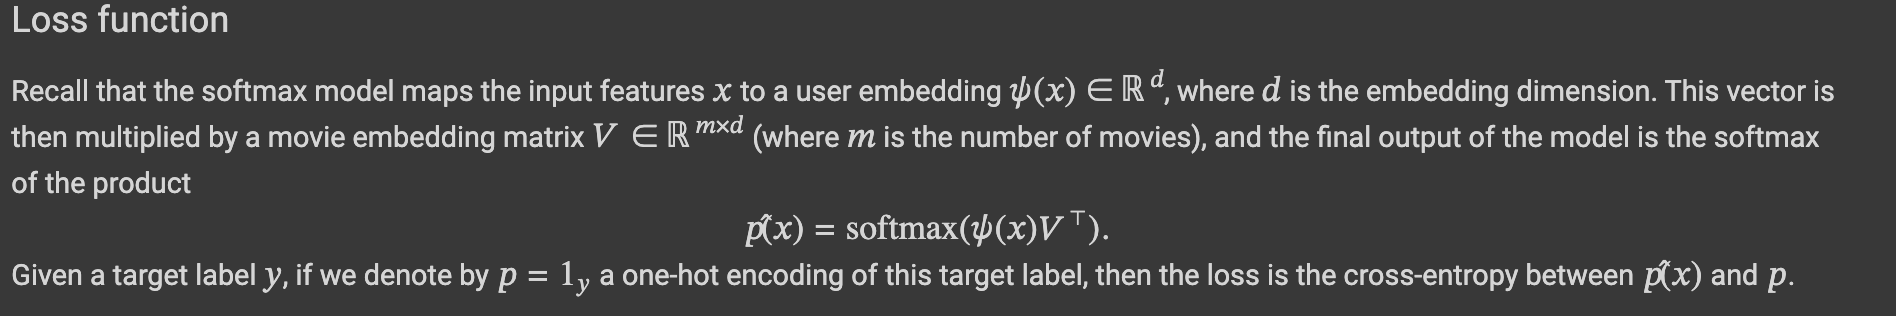

# Preprocessing

In [15]:
#First, need to perform some preprocessing to encode users and movies as integer indices.

In [16]:
user_encoder = LabelEncoder()
ratings['user'] = user_encoder.fit_transform(ratings['user_id'].values)

In [17]:
movie_encoder = LabelEncoder()
ratings['movie'] = movie_encoder.fit_transform(ratings['movie_id'].values)

In [18]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp,user,movie
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [45]:
# encode ratings - subtracts 1 from each rating, so if the original ratings were, for example, 1, 2, 3, the new encoded ratings become 0, 1, 2. This is suitable for a multi-class classification problem where the classes are typically indexed starting from 0.
ratings["rating"] = ratings["rating"].values.astype(np.float32)

In [43]:
# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])

In [46]:
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        len(ratings["user_id"].unique()),len(ratings["movie_id"].unique()), min_rating, max_rating
    )
)

Number of users: 943, Number of Movies: 1682, Min rating: 1.0, Max rating: 5.0


# Prepare training and validation data

In [22]:
ratings = ratings.sample(frac=1, random_state=42)
x = ratings[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [95]:
ratings["norm_ratings"] = ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [96]:
# Split the data into training and testing sets
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

In [97]:
train

,user_id,movie_id,rating,unix_timestamp,user,movie,norm_ratings
72822,655,6,4.000,887425812,654,5,0.750
45560,156,515,3.000,888185735,155,514,0.500
27615,497,56,4.000,878759659,496,55,0.750
5173,94,257,4.000,891724178,93,256,0.750
18100,428,332,4.000,885943749,427,331,0.750
...,...,...,...,...,...,...,...
93878,807,472,4.000,892530625,806,471,0.750
99783,934,786,1.000,891194089,933,785,0.000
57399,749,168,5.000,878847765,748,167,1.000
97106,717,245,4.000,884641842,716,244,0.750


In [25]:
x_train.shape

(90000, 2)

In [26]:
y_train.shape

(90000,)

In [27]:
num_users = len(ratings["user"].unique())
num_movies = len(ratings["movie"].unique())

In [29]:
num_users

943

In [28]:
num_movies

1682

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).



In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
            name='embedding-Layer-1-users',
        )
        self.user_bias = layers.Embedding(num_users, 1, name='embedding-Layer-2-userbias')
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
            name='embedding-Layer-3-movies'
        )
        self.movie_bias = layers.Embedding(num_movies, 1,name='embedding-Layer-4-moviesbias')

    def call(self, inputs):
        # output layer
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        # Sigmoid is used for binary classification methods where we only have 2 classes, while SoftMax applies to multiclass problems .
        # In fact, the SoftMax function is an extension of the Sigmoid function
        return tf.nn.sigmoid(x)

Note that in this case, the loss function is set to 'sparse_categorical_crossentropy' since we are dealing with a multi-class classification problem. The number of units in the softmax layer is equal to the number of unique ratings in your dataset.

In [108]:
# Set embedding size
embedding_size = 50

# User embedding
user_input = Input(shape=(1,), name='user-input')
user_embedding = Embedding(input_dim=len(user_encoder.classes_), output_dim=embedding_size, input_length=1)(user_input)
user_embedding = Flatten()(user_embedding)

# User bias
user_bias = Embedding(input_dim=len(user_encoder.classes_), output_dim=1, input_length=1)(user_input)
user_bias = Flatten()(user_bias)

# Movie embedding
movie_input = Input(shape=(1,), name='movie_input')
movie_embedding = Embedding(input_dim=len(movie_encoder.classes_), output_dim=embedding_size, input_length=1)(movie_input)
movie_embedding = Flatten()(movie_embedding)

# Movie bias
movie_bias = Embedding(input_dim=len(movie_encoder.classes_), output_dim=1, input_length=1)(movie_input)
movie_bias = Flatten()(movie_bias)

# Dot product of user and movie embeddings
dot_product = Dot(axes=1)([user_embedding, movie_embedding])

# Add user and movie biases to the dot product
added = Add()([dot_product, user_bias, movie_bias])

# Apply softmax activation
# softmax_output = Dense(units=len(ratings['rating'].unique()), activation='softmax')(added)
sigmoid_output = Dense(units=1, activation='sigmoid')(added)

# Combine the embeddings, biases, and softmax output into a single model
model = Model(inputs=[user_input, movie_input], outputs=sigmoid_output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [109]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user-input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 embedding_32 (Embedding)    (None, 1, 50)                47150     ['user-input[0][0]']          
                                                                                                  
 embedding_34 (Embedding)    (None, 1, 50)                84100     ['movie_input[0][0]']         
                                                                                            

In [110]:
model.get_config()

{'name': 'model_8',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'user-input'},
   'registered_name': None,
   'name': 'user-input',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'movie_input'},
   'registered_name': None,
   'name': 'movie_input',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Embedding',
   'config': {'name': 'embedding_32',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 1),
    'input_dim': 943,
    'output_dim': 50,
    'embeddings_initializer': {'module': 'keras.initializers',
     'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None},
     'r

In [91]:
ratings["norm_ratings"] = ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [92]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp,user,movie,norm_ratings
75721,877,381,4.000,882677345,876,380,0.750
80184,815,602,3.000,878694269,814,601,0.500
19864,94,431,4.000,891721716,93,430,0.750
76699,416,875,2.000,876696938,415,874,0.250
92991,500,182,2.000,883873556,499,181,0.250


In [111]:
history = model.fit(x=[train['user'], train['movie']],
                    y=train['norm_ratings'],
                    epochs=5, batch_size=64,
                    validation_data=([test['user'], test['movie']], test['norm_ratings']))

Epoch 1/5
1250/1250 [==============================] - 17s 13ms/step - loss: 0.6399 - accuracy: 0.2204 - val_loss: 0.6098 - val_accuracy: 0.2343
Epoch 2/5
1250/1250 [==============================] - 16s 13ms/step - loss: 0.5879 - accuracy: 0.2518 - val_loss: 0.5991 - val_accuracy: 0.2403
Epoch 3/5
1250/1250 [==============================] - 16s 13ms/step - loss: 0.5575 - accuracy: 0.2632 - val_loss: 0.6031 - val_accuracy: 0.2398
Epoch 4/5
1250/1250 [==============================] - 17s 13ms/step - loss: 0.5302 - accuracy: 0.2701 - val_loss: 0.6143 - val_accuracy: 0.2371
Epoch 5/5
1250/1250 [==============================] - 16s 13ms/step - loss: 0.5111 - accuracy: 0.2731 - val_loss: 0.6280 - val_accuracy: 0.2340


In [112]:
history.history

{'loss': [0.6399335861206055,
  0.5879239439964294,
  0.5574997067451477,
  0.5301510095596313,
  0.5111223459243774],
 'accuracy': [0.22043749690055847,
  0.25183749198913574,
  0.26317501068115234,
  0.27012500166893005,
  0.27309998869895935],
 'val_loss': [0.6097533106803894,
  0.5990659594535828,
  0.6030934453010559,
  0.6143249273300171,
  0.628023087978363],
 'val_accuracy': [0.23430000245571136,
  0.24025000631809235,
  0.2398499995470047,
  0.2371000051498413,
  0.23399999737739563]}

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

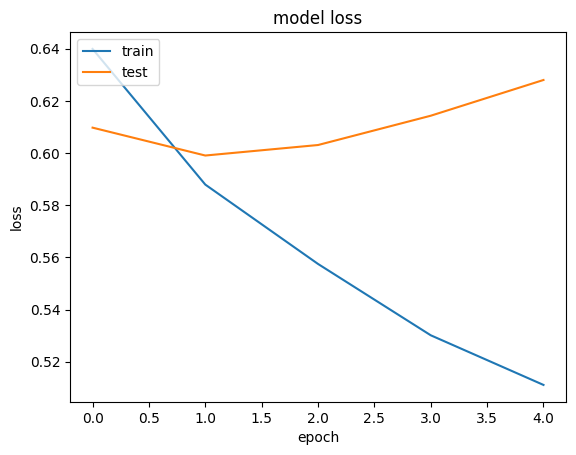

In [113]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [114]:
# Example of making predictions
user_id = user_encoder.transform([878])[0]
movie_id = movie_encoder.transform([382])[0]
print(movie_id)

prediction = model.predict([np.array([user_id]), np.array([movie_id])])
print(f'Predicted rating: {prediction[0][0]}')

381
1/1 [==============================] - 0s 21ms/step
Predicted rating: 0.41034531593322754


/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/.crs-ds-venv/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [99]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp,user,movie,norm_ratings
75721,877,381,4.000,882677345,876,380,0.750
80184,815,602,3.000,878694269,814,601,0.500
19864,94,431,4.000,891721716,93,430,0.750
76699,416,875,2.000,876696938,415,874,0.250
92991,500,182,2.000,883873556,499,181,0.250


In [115]:
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

In [116]:
mark_genres(movies, genre_c_name)

In [117]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre,all_genres
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,Children's,Animation-Children's-Comedy
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,1,0,0,Adventure,Action-Adventure-Thriller
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,Thriller,Thriller
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,Action,Action-Comedy-Drama
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,1,0,0,Thriller,Crime-Drama-Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Drama,Drama
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,1,0,1,0,0,Romance,Romance-Thriller
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,1,0,0,0,0,Drama,Drama-Romance
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Comedy,Comedy


In [124]:

# Let us get a user and see the top recommendations.
# user_id = ratings.user_id.sample(1).iloc[0]
user_id = 1
# Movie embeddings for movies not watched
movies_watched_by_user = ratings[ratings.user_id == user_id]
movies_not_watched = movies[
    ~movies["movie_id"].isin(movies_watched_by_user.movie_id.values)
]["movie_id"]
# movies_not_watched = list(
#     set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
# )
# movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
movies_not_watched_encoded = [ratings[ratings.user_id == user_id][ for x in movies_not_watched]


In [141]:
movies_watched_by_user

,user_id,movie_id,rating,unix_timestamp,user,movie,norm_ratings
6234,1,233,2.000,878542552,0,232,0.250
4232,1,159,3.000,875073180,0,158,0.500
48078,1,238,4.000,875072235,0,237,0.750
17672,1,100,5.000,878543541,0,99,1.000
24547,1,63,2.000,878543196,0,62,0.250
...,...,...,...,...,...,...,...
40600,1,182,4.000,875072520,0,181,0.750
73972,1,43,4.000,878542869,0,42,0.750
7561,1,175,5.000,875072547,0,174,1.000
12183,1,252,2.000,875240677,0,251,0.250


In [130]:
movies_not_watched

272      273
273      274
274      275
275      276
276      277
        ... 
1677    1678
1678    1679
1679    1680
1680    1681
1681    1682
Name: movie_id, Length: 1410, dtype: int64

In [129]:
movies_not_watched_encoded

array([ 380,  601,  430, ..., 1372,  851, 1309])

In [131]:
# user embedding
user_encoder = ratings[ratings["user_id"]==user_id]["user"].unique()

In [132]:
user_encoder

array([0])

In [134]:
len(movies_not_watched)

1410

In [140]:
len(movies_not_watched_encoded)

1410

In [139]:

# user movie embedding
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched),movies_not_watched_encoded )
)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)

In [136]:
movies_not_watched

272      273
273      274
274      275
275      276
276      277
        ... 
1677    1678
1678    1679
1679    1680
1680    1681
1681    1682
Name: movie_id, Length: 1410, dtype: int64

In [ ]:


# Predict ratings for the given user and movies not watched by the user
ratings_predicted = model.predict(user_movie_array).flatten()

# select top 10 most rated
top_ratings_indices = ratings_predicted.argsort()[-10:][::-1]

recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movie_id.values
)
movie_df_rows = movies[movies["movie_id"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.all_genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movies[movies["movie_id"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.all_genres)

In [ ]:
# Function to find nearest neighbors based on cosine similarity
def find_nearest_neighbors(target_embedding, all_embeddings, k=5):
    similarities = np.dot(all_embeddings, target_embedding) / (np.linalg.norm(all_embeddings, axis=1) * np.linalg.norm(target_embedding))
    nearest_neighbors_indices = np.argsort(similarities)[::-1][:k]
    return nearest_neighbors_indices

In [ ]:
target_user_id = user_encoder.transform(['your_target_user_id'])[0]
target_user_embedding = all_user_embeddings[target_user_id]
nearest_user_indices = find_nearest_neighbors(target_user_embedding, all_user_embeddings)

# Decode the user IDs back to their original values
nearest_user_ids = user_encoder.inverse_transform(nearest_user_indices)

print(f"Nearest neighbors for user {target_user_id}: {nearest_user_ids}")